### **Introducing Graph Attention Layer**
- The main idea behind GAT is that some nodes are more important than others. The graph attention layer produces weighting factor that considers the importance of node features.
- Define the weighting factor as attention scores and let $\alpha_{ij}$ be the attention score between nodes $i$ and $j$.
$$h_i = \sum_{j \in N_i} \alpha_{ij}Wx_j$$
- Node features from a central node $i$ and a neighbour $j$ is represented by a concatenation between the hidden vector, $[w{x_i} || w{x_j}]$. An additional linear transformation is applied with a learnable weight matrix $W_{att}$. During training, the matrix learns weights to produce attention coefficients $\alpha_{ij}$.
$$a_{ij}=W_{att}^T[wx_i ||wx_j]$$
- Leaky ReLU is then applied and attention scores are normalized using the softmax function.
$$e_{ij} = LeakyReLU(a_{ij})$$
$$\alpha_{ij} = softmax(e_{ij}) = \frac{exp(e_{ij})}{\sum_{k \in N_i} exp(e_{ik})}$$
- However, self-attention is not very stable. Hence, multi-attention calculates multiple embeddings with their own attention scores instead of a single one.
- Each instance produces an embedding $h_i^k$ where $k$ is the index of the attention head. There are two ways of combining these results.
1. Averaging: Sum the different embeddings and normalize by the number of attention heads $n$
$$h_i = \frac{1}{n}\sum_{k=1}^{n}\sum_{j \in N_i} \alpha_{ij}^kW^kx_j$$
2. Concatenation: Concatenate the different embeddings
$$h_i = ||_{k=1}^{n} \sum_{j \in N_i} \alpha_{ij}^k W^k x_j$$
- We choose the concatenation scheme when it's a hidden layer and the average scheme when it's the last layer of a network.


### **Implementing Graph Attention Network**

Processing...
Done!


<BarContainer object of 37 artists>

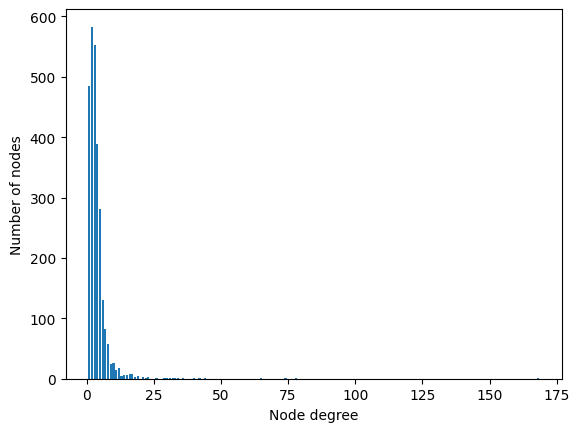

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [10]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

class GCN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads = 8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads = heads)
    self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads = 1)

  def forward(self, x, edge_index):
    h = F.dropout(x, p = 0.6, training = self.training)
    h = self.gat1(h, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p = 0.6, training = self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim = 1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr = 0.01, weight_decay = 5e-4)

    self.train()
    for epoch in range(epochs + 1):
      optimizer.zero_grad()
      out = self(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      loss.backward()
      optimizer.step()

      if(epoch % 20 == 0):
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

  @torch.no_grad()
  def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [11]:
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

gcn.fit(data, epochs = 100)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gat1): GATv2Conv(1433, 16, heads=8)
  (gat2): GATv2Conv(128, 7, heads=1)
)
Epoch   0 | Train Loss: 1.983 | Train Acc: 12.14% | Val Loss: 1.98 | Val Acc: 10.60%
Epoch  20 | Train Loss: 0.022 | Train Acc: 99.29% | Val Loss: 1.32 | Val Acc: 70.60%
Epoch  40 | Train Loss: 0.020 | Train Acc: 98.57% | Val Loss: 1.23 | Val Acc: 70.00%
Epoch  60 | Train Loss: 0.024 | Train Acc: 100.00% | Val Loss: 1.18 | Val Acc: 70.60%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 1.15 | Val Acc: 72.80%
Epoch 100 | Train Loss: 0.020 | Train Acc: 100.00% | Val Loss: 1.05 | Val Acc: 75.60%

GCN test accuracy: 80.00%

